In [ ]:
# default_exp model.conv

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [ ]:
# hide
from nbdev.showdoc import *

# M5 Base Model

In [ ]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.data.procs import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastai2.tabular.model import *
from fastai2.torch_basics import *
from fastai2.callback.all import *
from fastseq.metrics import *

In [ ]:
from tqdm import tqdm

In [ ]:
path = Path('../data/m5_tiny/rows')

In [ ]:
list(path.glob('*.json'))[0]

Path('../data/m5_tiny/rows/FOODS_2_176_CA_1.json')

In [ ]:
new_path = Path('../data/m5_tiny/rows_800')
if not new_path.exists(): new_path.mkdir()
for i, f in tqdm(enumerate(list(path.glob('*.json')))):
    f.copy(new_path / f.name)
    if i == 800:
        break

# (path / '.ts_meta').copy(new_path / '.ts_meta')

599it [00:00, 3146.31it/s]


In [ ]:
path = new_path

In [ ]:
# Path('/home/tako/dev/fastseq/data/m5_tiny/rows/.ts_meta').copy(path / '.ts_meta' )

In [ ]:
import orjson
meta = get_meta(path)
meta.del_col('d.1')
meta.del_col('id')
meta['col_names']

{'cat_names': ['item_id', 'store_id', 'cat_id', 'state_id', 'dept_id'],
 'con_names': [],
 'ts_cat_names': ['weekday', 'date'],
 'ts_con_names': ['sales',
  'snap_CA',
  'prices',
  'snap_TX',
  'year',
  'snap_WI',
  'month',
  'wm_yr_wk',
  'wday']}

In [ ]:
meta['classes'] = get_meta(path)['classes']

In [ ]:
open(path / '.ts_meta','wb').write(orjson.dumps(dict(meta)))

1058698

{'Train': 7209, 'Val': 2403, 'Validation': 801, 'Evaluation': 801}


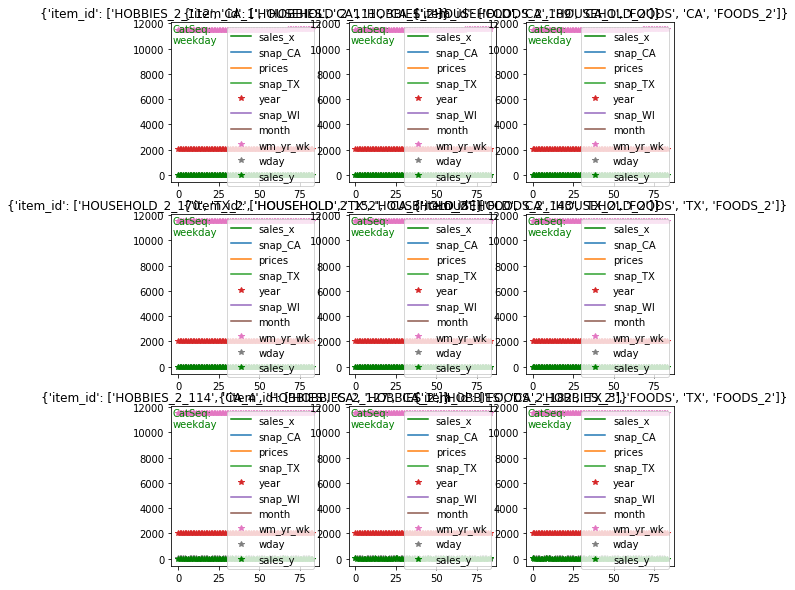

In [ ]:
lookback, horizon = 28*2, 28

dl = MTSDataLoaders.from_m5_path(path, 'sales', horizon = horizon, lookback = lookback, step = 28,
                                  train_start = 1500, verbose = True,
#                                  procs = [DateProc(path, 'date')]
#                                   after_batch = [NormalizeSeqMulti(n_its=5,skip=[5])]
                                 )
dl.show_batch()

0_<class 'fastseq.core.TensorSeq'> torch.Size([64, 1, 56])
1_<class 'fastseq.core.TensorSeq'> torch.Size([64, 8, 84])
2_<class 'fastseq.data.load.CatSeqI'> torch.Size([64, 2, 84])
3_<class 'fastseq.data.load.TensorCatI'> torch.Size([64, 5])
4_<class 'fastseq.core.TensorCon'> torch.Size([64, 0])
5_<class 'fastseq.core.TensorSeq'> torch.Size([64, 1, 84])


(TensorSeq(0.0086, device='cuda:0'),
 TensorSeq(1.0367, device='cuda:0'),
 TensorSeq(-2.7674e-08, device='cuda:0'),
 TensorSeq(0.9272, device='cuda:0'))

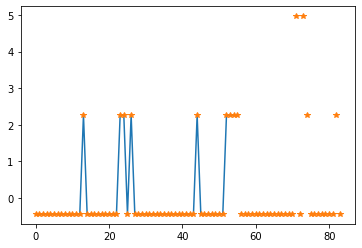

In [ ]:
for o in dl.train:
    o._dict()
    break
for k,v in o._dict().items():
    print(k,v)
plt.plot(o[0][0,0].cpu())
plt.plot(o[-1][0,0].cpu(),'*')
o[-1].mean(),o[-1].std(),o[0].mean(),o[0].std()

In [ ]:
# export
def pad_start(x, length = 28, fill = 0):
    return torch.cat([torch.ones_like(x)[:,:,:length]*fill, x],-1 )

30.5 µs ± 545 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


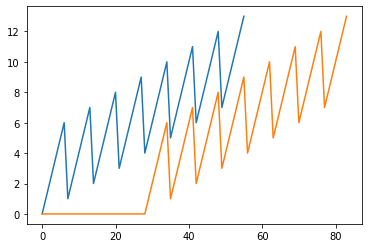

In [ ]:
x = tensor([unpack_list([[i+j for j in range(7)] for i in range(4*2)])]*64)[:,None,:]
plt.plot(x[0,0,:])
%timeit pad_start(x)
_x = pad_start(x)
plt.plot(_x[0,0,:])

In [ ]:
# export
def average_week(x, week_len = 7):
    r = []
    for i in range(week_len):
        r.append(x[:,:,i::7].mean(-1))
    return torch.cat([r[i%week_len] for i in range(28*3)],1)[:,None,:]

torch.Size([64, 1, 84])


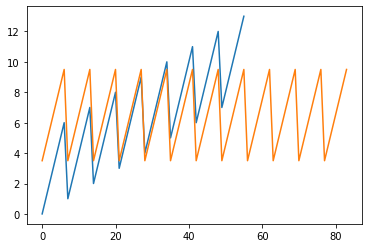

In [ ]:
x = tensor([unpack_list([[i+j for j in range(7)] for i in range(4*2)])]*64).float()[:,None,:]
plt.plot(x[0,0,:])
_x = average_week(x)
print(_x.shape)
plt.plot(_x[0,0,:])

In [ ]:
#export
def emb_sz_rule(n_cat):
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    print(n, n_cat, sz)
    return n_cat,sz

def get_emb_sz(to, typ, sz_dict=None):
    return [_one_emb_sz(to.meta['classes'], col, sz_dict) for col in to.meta['col_names'][typ]]

In [ ]:
ConvLayer??

Init signature:
ConvLayer(
    ni,
    nf,
    ks=3,
    stride=1,
    padding=None,
    bias=None,
    ndim=2,
    norm_type=<NormType.Batch: 1>,
    bn_1st=True,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
    **kwargs,
)
Source:        
class ConvLayer(nn.Sequential):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init='auto', xtra=None, bias_std=0.01, **kwargs):
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv_func = _conv_func(ndim, transpose=transpo

In [ ]:
# export
class SeqTabConv(Module):
    """Basic model for sequential data."""
    def __init__(self, horizon, lookback, emb_szs = None, emb_szs_ts = None, ts_con_chn = None, con_chn = None,
                 layers = [32, 32], y_range=[-5,5]):
        self.horizon, self.lookback = horizon, lookback
        if emb_szs is not None:
            self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])  
            self.n_emb = sum(e.embedding_dim for e in self.embeds)      
        else:
            self.n_emb=0
            
        if emb_szs is not None:
            self.embeds_ts = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs_ts])  
            self.n_emb_ts = sum(e.embedding_dim for e in self.embeds_ts)      
        else:
            self.n_emb_ts=0  
        f_in = 8
        self.layers = nn.Sequential(*[ConvLayer(f_in, 1, ks = 1, ndim=1, bias = True),
                                     ])
        # self.layers = nn.Sequential(*[LinBnDrop(f_in, 32, act=nn.ReLU(), p = .1),
        #                                 LinBnDrop(32, 32, act=nn.ReLU(), p = .1),
        #                               LinBnDrop(32,1, bn = False)
        #                              ])
        
    def forward(self, x, ts_con, ts_cat, cat, con):  
        arange = torch.arange(ts_con.shape[-1]).to(default_device())*torch.ones_like(ts_con)*0
        return self.layers(torch.cat([arange],1))

        
        

In [ ]:
lookback, horizon = 28*2, 28
emb_szs = get_emb_sz(dl.train,'cat_names', {'item_id':3})
emb_szs_ts = get_emb_sz(dl.train,'ts_cat_names', {'date':3, 'd.1':1})
mdl = SeqTabConv(horizon,lookback,
             emb_szs = emb_szs,
             emb_szs_ts = emb_szs_ts,             
            ).to(default_device())
out = mdl(*o[:-1])
shape = list(out.shape)
test_eq(shape,[64,1,lookback+horizon])
print(shape)
print(o[-1][0,:,-28:])
print(out[0,:,-28:])
print(F.mse_loss(o[-1][0], out[0]))
print(shape)
del mdl


item_id 3049 3
store_id 10 6
cat_id 3 3
state_id 3 3
dept_id 7 5
weekday 7 5
date 1969 3
[64, 1, 84]
tensor([[-0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337,
         -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337,  4.9631,
         -0.4337,  4.9631,  2.2647, -0.4337, -0.4337, -0.4337, -0.4337, -0.4337,
         -0.4337, -0.4337,  2.2647, -0.4337]], device='cuda:0')
tensor([[0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010]], device='cuda:0', grad_fn=<SliceBackward>)
tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
[64, 1, 84]


In [ ]:
# export
from fastseq.metrics import *
class M5Learner(Learner): pass

@delegates(M5Learner.__init__)
def SeqTabLearner(dls, layers=None,metrics=None, emb_szs=None, emb_szs_ts=None, **kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `SeqTab` created using the remaining params."
    if layers is None: layers = [200,100]    
    emb_szs = get_emb_sz(dls.train,'cat_names', {} if emb_szs is None else emb_szs)
    emb_szs_ts = get_emb_sz(dls.train,'ts_cat_names', {} if emb_szs_ts is None else emb_szs_ts)
    dls.train.shuffle = True
    model = SeqTabConv(dls.train.horizon, dls.train.lookback, emb_szs = emb_szs, emb_szs_ts=emb_szs_ts,
                       layers = layers)
    return Learner(dls, model, loss_func = ForcastLoss(F.mse_loss,28*2), opt_func= Adam,
                   metrics=L(metrics)+L(LossPart(28*2,28*3,'forecast_mae',loss_func=mae), 
                                        LossPart(28*2,28*3,'forecastloss',loss_func=F.mse_loss), 
                                        LossPart(0,28*3,'allloss',loss_func=F.mse_loss) 
                                       ), **kwargs)

In [ ]:
learn = SeqTabLearner(dl,# cbs = ActivationStats(every=4, with_hist=True),
                      emb_szs_ts = {'date' : 3, 'd.1' : 1}, emb_szs={'item_id' : 3})

item_id 3049 3
store_id 10 6
cat_id 3 3
state_id 3 3
dept_id 7 5
weekday 7 5
date 1969 3


(5.248074330665986e-08, 7.585775847473997e-07)

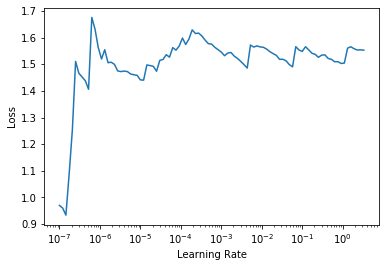

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,forecast_mae,forecastloss,allloss,time
0,1.555931,1.457816,0.025962,0.052065,0.013165,00:04


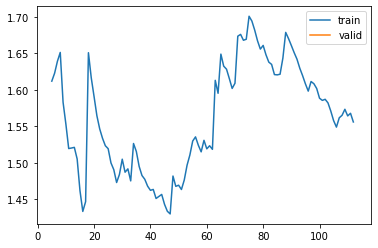

In [ ]:
learn.fit(1, 1e-2, wd = .01)
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,forecast_mae,forecastloss,allloss,time
0,1.587926,1.457816,0.025962,0.052065,0.019180,00:04


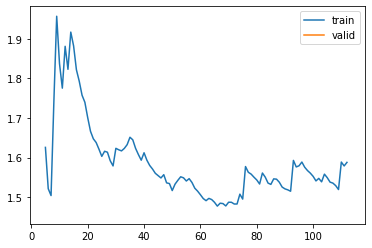

In [ ]:
learn.fit(1, 1e-4, wd = .01)
learn.recorder.plot_loss()

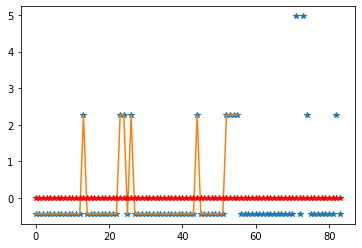

In [ ]:
out = learn.model(*o[:-1])
import seaborn as sns
plt.plot(o[-1][0,0].cpu(),'*')
plt.plot(o[0][0,0].cpu())
plt.plot(out[0,0].cpu().detach().numpy(),'r*')

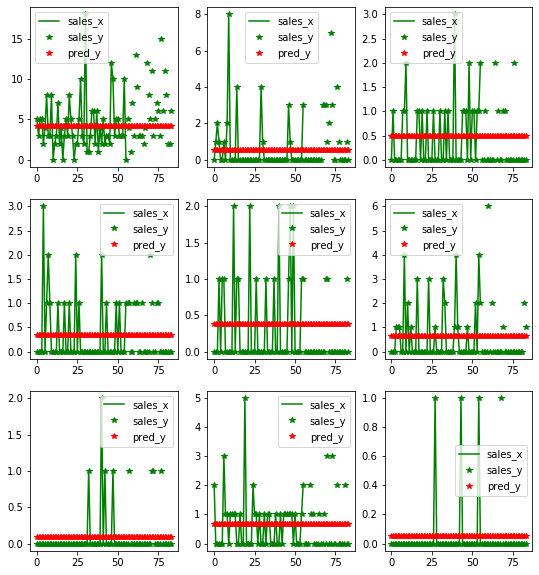

In [ ]:
learn.show_results(0, show_kwargs = dict(extra = False))

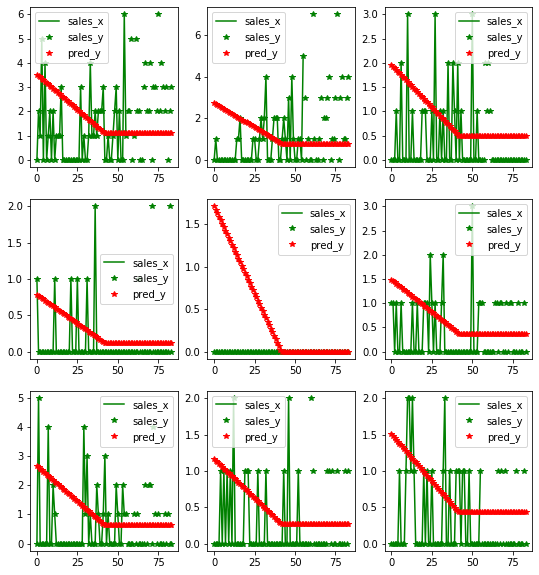

In [ ]:
learn.show_results(1, show_kwargs = dict(extra = False))

epoch,train_loss,valid_loss,forecast_mae,forecastloss,allloss,time
0,1.531378,1.567880,0.026269,0.055996,0.006222,00:15


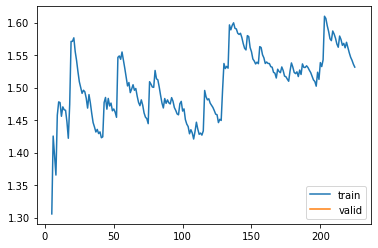

In [ ]:
learn.fit(1, 1e-1)
learn.recorder.plot_loss()

In [ ]:
for i in range(0,len(learn.activation_stats.stats[0])):
    learn.activation_stats.plot_layer_stats(i)
    learn.activation_stats.color_dim(i)

IndexError: list index out of range

In [ ]:
learn.summary()

SeqTabConv (Input shape: ['64 x 1 x 56', '64 x 8 x 84', '64 x 2 x 84', '64 x 5', '64 x 0'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            64 x 3               9,147      True      
________________________________________________________________
Embedding            64 x 6               60         True      
________________________________________________________________
Embedding            64 x 3               9          True      
________________________________________________________________
Embedding            64 x 3               9          True      
________________________________________________________________
Embedding            64 x 5               35         True      
________________________________________________________________
Embedding            64 x 84 x 5          35         True      
________________________________________________________________
Embedding            64 x 84 x 3          5,907      True      
______

In [ ]:
learn.fit(2, 1e-1)
learn.recorder.plot_loss()

KeyboardInterrupt: 

In [ ]:
learn.fit(30, 1e-5)
learn.recorder.plot_loss()

Exception ignored in: <function _releaseLock at 0x7f847adc2ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 25667, 25668) exited unexpectedly

epoch,train_loss,valid_loss,mae,smape,time
0,1.700850,3.631715,1.063029,1.057062,00:20
1,1.642673,3.684052,1.020913,0.995038,00:19


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f696c9d6200>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f696c9d6200>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 138, in join
    w.join()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.7/multiprocessi

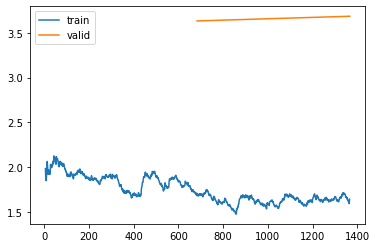

In [ ]:
learn.fit(2, 1e-1)
learn.recorder.plot_loss()

In [ ]:
ResBlock??

Init signature:
ResBlock(
    expansion,
    ni,
    nf,
    stride=1,
    groups=1,
    reduction=None,
    nh1=None,
    nh2=None,
    dw=False,
    g2=1,
    sa=False,
    sym=False,
    norm_type=<NormType.Batch: 1>,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    ndim=2,
    ks=3,
    pool=<function AvgPool at 0x7f6964139a70>,
    pool_first=True,
    padding=None,
    bias=None,
    bn_1st=True,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
)
Source:        
class ResBlock(nn.Module):
    "Resnet block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, stride=1, groups=1, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=3,
                 pool=AvgPool, pool_first=True, **kwargs):
        super().__init__()
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
   

(3.0199518619156154e-08, 1.9054607491852948e-06)

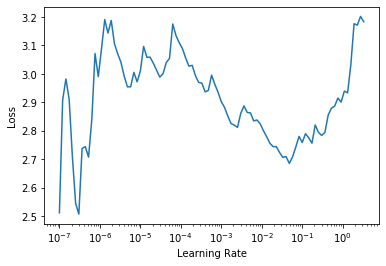

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,time
0,3.087510,3.726764,1.075242,1.018762,00:18
1,2.612622,3.802750,1.129334,1.037828,00:18
2,2.665844,3.810264,1.108218,1.014511,00:18


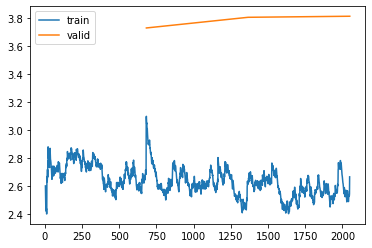

In [ ]:
learn.fit(3, 1e-3)
learn.recorder.plot_loss()

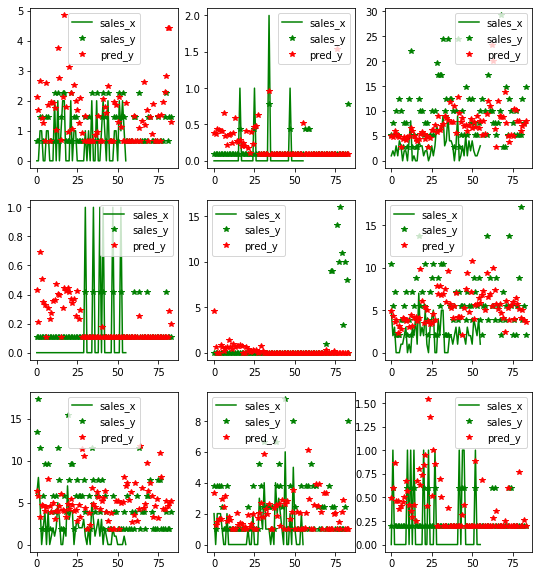

In [ ]:
learn.show_results(show_kwargs = dict(extra = False))

In [ ]:
inputs,preds,targs,decoded,losses = learn.get_preds(3, with_decoded = True, with_input=True, with_loss=True)

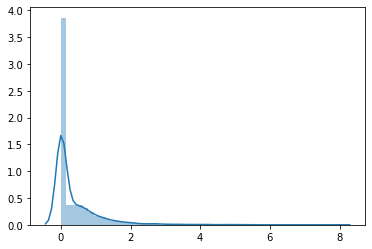

In [ ]:
import seaborn as sns
sns.distplot(decoded[-28:].cpu())

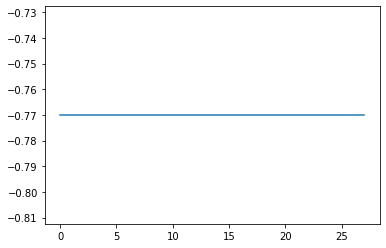

In [ ]:
plt.plot(targs[0,:,-28:].T)

In [ ]:

# inputs,preds,targs,decoded,losses
def make_pred(learn, dl = 2):
    inputs,preds,targs,decoded,losses = learn.get_preds(3, with_decoded = True, with_input=True, with_loss=True)
    predictions = (decoded ).round() #TODO std
    return predictions[:,0,:]
    

In [ ]:

for pred in make_pred(learn, dl = 2):
    o =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
    print(o)
    break
plt.plot(pred)        

In [ ]:
plt.plot(pred[-1,].T)

In [ ]:

def make_submision_file(learn):
    dct = {}
    for i, (file, pred) in enumerate(zip(learn.dls[2].dataset, make_pred(learn, 2))):
        name = file.name.replace('.json','_validation')
        pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
        dct[name] = pred

    for i, (file, pred) in enumerate(zip(learn.dls[3].dataset, make_pred(learn, 3))):
        name = file.name.replace('.json','_evaluation')
        pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
        dct[name] = pred
    return dct

In [ ]:
# export
dct = make_submision_file(learn)
dct['HOBBIES_1_028_CA_1_validation']

In [ ]:
def make_file(learn, dct):
    with open(learn.path / 'submision_file.csv','w') as f_w:
        with open(Path('../data/m5/sample_submission.csv')) as f:
            f_w.write('id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28')
            for line in f:
                f.write(dct[line.split(',')[0]])
            
M5Learner.make_submision_file = make_submision_file

In [ ]:

make_file(learn, dct)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f '../data/m5/rows2/submision_file.csv' -m 'initial sub 0.0.1'

In [ ]:
# hide
from nbdev.export import *
notebook2script()

In [ ]:
git_add('11_model.conv.ipynb', commit_msg='working loop')

Converted 11_model.conv.ipynb.


['/home/tako/dev/fastseq/fastseq/model/conv.py',
 '/home/tako/dev/fastseq/nbs/11_model.conv.ipynb']